In [17]:
#1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor
import pickle
import os

# Plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (8, 4)


In [18]:
#2
# Load dataset
file_path = 'Housing.csv'
df = pd.read_csv(file_path)

# Identify target column
price_column = None
for col in df.columns:
    if 'price' in col.lower() or 'value' in col.lower() or 'cost' in col.lower():
        price_column = col
        break

print(f"Target column: {price_column}")


Target column: price


In [19]:
#3
# Fill missing values
missing_values = df.isnull().sum()
columns_with_missing = missing_values[missing_values > 0].index.tolist()

for col in columns_with_missing:
    if df[col].dtype in ['int64', 'float64']:
        df[col].fillna(df[col].mean(), inplace=True)
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)

# Double-check
print("Remaining missing values:")
print(df.isnull().sum()[df.isnull().sum() > 0])


Remaining missing values:
Series([], dtype: int64)


In [20]:
#4
# Separate features and target
X = df.drop(price_column, axis=1)
y = df[price_column]

# Train-validation-test split
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=42)


In [21]:
#5
# Identify column types
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# Pipelines
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Preprocessor
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])


In [22]:
#6
# Model
model = HistGradientBoostingRegressor(random_state=42)

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])


In [34]:
#7
# Param grid
param_grid = {
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_iter': [100, 200, 300],
    'model__max_leaf_nodes': [31, 50, 100],
    'model__min_samples_leaf': [20, 30, 50]
}

# Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['area',
                                                                          'bedrooms',
                                                                          'bathrooms',
                                                                          'stories',
                                                                          'parking']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OrdinalEncoder(handle_unknown='use_enc...
                                                                          'guestroom',
                                                                          'basement',
                                                                          'hotwaterheating',
                                                                          'airconditioning',
                                                                          'prefarea',
                                                                          'furnishingstatus'])])),
                                       ('model',
                                        HistGradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_iter': [100, 200, 300],
                         'model__max_leaf_nodes': [31, 50, 100],
                         'model__min_samples_leaf': [20, 30, 50]},
             scoring='neg_root_mean_squared_error')

In [37]:
 #8
# Best model
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)

val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

print("\nBest Hyperparameters:")
print(grid_search.best_params_)
print(f"Validation RMSE: {val_rmse:.2f}")
print(f"Validation R²: {val_r2:.4f}")



Best Hyperparameters:
{'model__learning_rate': 0.1, 'model__max_iter': 100, 'model__max_leaf_nodes': 31, 'model__min_samples_leaf': 30}
Validation RMSE: 1017617.18
Validation R²: 0.6483


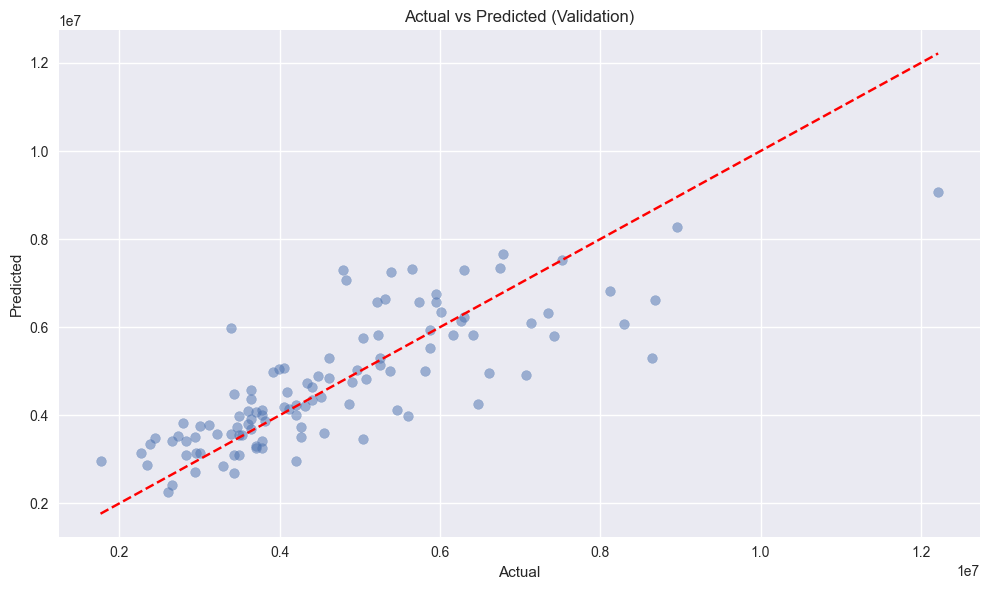

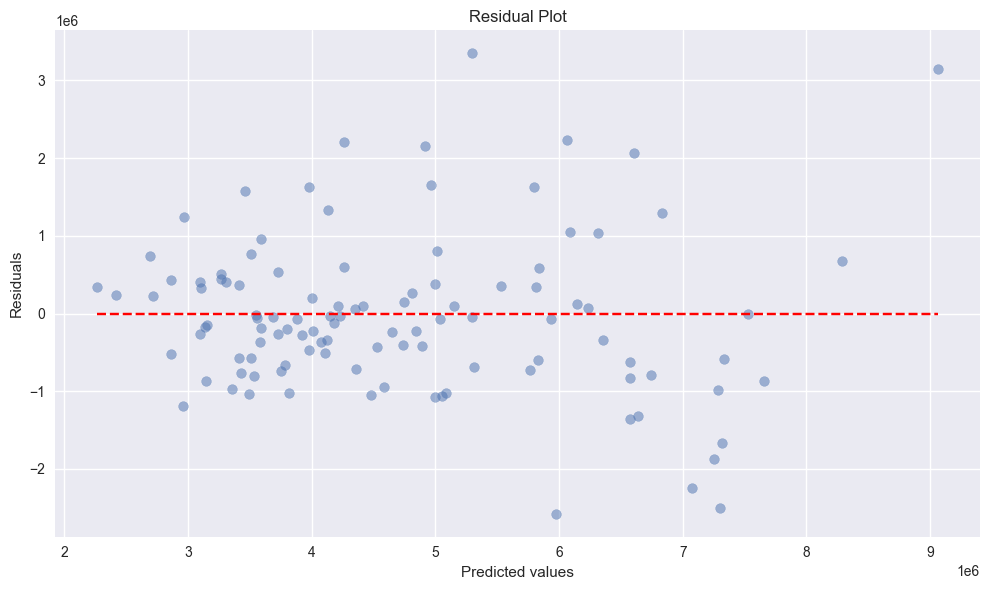

In [25]:
#9
# Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (Validation)')
plt.tight_layout()
plt.show()

# Residual plot
residuals = y_val - y_val_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_val_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_val_pred.min(), xmax=y_val_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()


In [26]:
#10
y_test_pred = best_model.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print("\nTest results:")
print(f"RMSE: {test_rmse:.2f}")
print(f"R²: {test_r2:.4f}")



Test results:
RMSE: 1371216.54
R²: 0.6280


In [27]:
#11
mean_absolute_percentage_error = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
accuracy_percentage = 100 - mean_absolute_percentage_error

print(f"\nApproximate prediction accuracy: {accuracy_percentage:.2f}%")




Approximate prediction accuracy: 78.98%


In [28]:
mean_absolute_percentage_error = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
accuracy_percentage = 100 - mean_absolute_percentage_error

print(f"\nApproximate prediction accuracy: {accuracy_percentage:.2f}%")


Approximate prediction accuracy: 78.98%


In [29]:
model_filename = 'house_price_prediction_model.pkl'
model_path = os.path.join(os.getcwd(), model_filename)

with open(model_path, 'wb') as file:
    pickle.dump(best_model, file)

print(f"\nThe model has been successfully saved as '{model_filename}'")
print(f"Full path: {model_path}")



The model has been successfully saved as 'house_price_prediction_model.pkl'
Full path: C:\Users\User\Desktop\CNN\house_price_prediction_model.pkl
